<a href="https://colab.research.google.com/github/raulbenitez/ML_DL_INTERPRETABILITY/blob/main/DL_interpretability_blobs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Generate synthetic data

In [1]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import requests
# Save datagenerators as file to colab working directory
url = 'https://raw.githubusercontent.com/raulbenitez/ML_DL_INTERPRETABILITY/main/DL/generator.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import 
with open('generator.py', 'w') as f:
    f.write(r.text)

# now we can import
import generator

We first generate the data, train the model and then look at some visual explanations

In [3]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

In [12]:
#hyperparameters and blank image and label generation
N = 6000
size = 64
big_blob_size = 8
big_blob_range = 2
labels = np.random.randint(3, size = N)
imgs = np.zeros((size, size, N))

In [13]:
#fill array with corresponding images
# the function generate_new_blob_img is imported from our generator file. In order to replicate the results of the paper, use exactly these parameters
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_new_blob_img(ellipse=True, size=size,num_big_blobs=4)
    elif labels[i] == 1:
        x = generator.generate_new_blob_img(ellipse = False, size = size, num_big_blobs=4)
    elif labels[i] == 2:
        x = generator.generate_new_blob_img(ellipse= False, size = size, num_big_blobs=0)
    imgs[:,:,i] = x

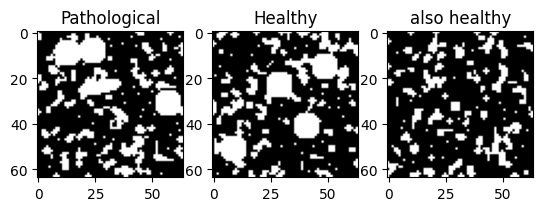

In [14]:
#display one pathological and one healthy image
fig, ax = plt.subplots(1,3)

path_img = imgs[:,:,np.where(labels == 0)[0][0]]
healthy_img = imgs[:,:,np.where(labels ==1)[0][0]]
healthy2_img = imgs[:,:,np.where(labels ==2)[0][0]]

ax[0].imshow(path_img, cmap=plt.cm.gray)
ax[1].imshow(healthy_img, cmap=plt.cm.gray)
ax[2].imshow(healthy2_img, cmap = plt.cm.gray)

ax[0].set_title("Pathological");
ax[1].set_title("Healthy");
ax[2].set_title('also healthy');

In [15]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.expand_dims(imgs, -1)
X = np.transpose(X, (2,1,0,3))
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(6000, 64, 64, 1)

# The DL model

Here we define the model. It is a standard three layer CNN architecture. If this happens to not work for your dataset, consider changing the following:
* Add new convolutional blocks
* change the dropout change
* change the kernel sizes (although too large kernels might result in poor spatial resolution of the heatmaps)


In [16]:
# Model hyperparameters
num_classes = 3
input_shape = (size, size, 1)
batch_size = 64
epochs = 30
conv_size=(3,3)
save = False #if running the entire notebook, always set this to false! otherwise you might overwrite something if you forget to change the name of the file
# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [17]:
#create model
#the model is a standard three layer CNN architecture. If this happens to not work on your dataset, some useful things might include:

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                      

In [18]:
opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="categorical_crossentropy", optimizer = opt, metrics=["accuracy"])

#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/30
57/57 [==============================] - 45s 783ms/step - loss: 3.5939 - accuracy: 0.6432 - val_loss: 24.7934 - val_accuracy: 0.3507
Epoch 2/30
57/57 [==============================] - 45s 796ms/step - loss: 1.7131 - accuracy: 0.7756 - val_loss: 75.4386 - val_accuracy: 0.3507
Epoch 3/30
57/57 [==============================] - 45s 786ms/step - loss: 1.1688 - accuracy: 0.8311 - val_loss: 103.6477 - val_accuracy: 0.3507
Epoch 4/30
57/57 [==============================] - 48s 842ms/step - loss: 1.0339 - accuracy: 0.8635 - val_loss: 61.0982 - val_accuracy: 0.3507
Epoch 5/30
57/57 [==============================] - 45s 786ms/step - loss: 0.8593 - accuracy: 0.8897 - val_loss: 69.2084 - val_accuracy: 0.3507
Epoch 6/30
57/57 [==============================] - 46s 815ms/step - loss: 0.6573 - accuracy: 0.9093 - val_loss: 30.6088 - val_accuracy: 0.6343
Epoch 7/30
57/57 [==============================] - 44s 776ms/step - loss: 0.4480 - accuracy: 0.9386 - val_loss: 39.7579 - val_accuracy

In [14]:
#run this if you want to save the model and have set save to True. 
if save:
    model.save("/content/drive/MyDrive/DL INTERPRETABILITY/model40_padding")

In [19]:
model.save("/content/drive/MyDrive/DL INTERPRETABILITY/model40_padding")

In [15]:
model = tf.keras.models.load_model("/content/drive/MyDrive/DL INTERPRETABILITY/model40_padding")

OSError: ignored

## Model evaluation 


In [20]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['Pathological', 'Healthy', 'also healthy']

score = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(X_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 2.812983989715576
Test accuracy: 0.7873737215995789
62/62 [==============================] - 5s 84ms/step
              precision    recall  f1-score   support

Pathological       1.00      0.37      0.54       669
     Healthy       0.61      1.00      0.76       670
also healthy       1.00      1.00      1.00       641

    accuracy                           0.79      1980
   macro avg       0.87      0.79      0.77      1980
weighted avg       0.87      0.79      0.76      1980



In [88]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred_DL_full)

array([[248, 421,   0],
       [  0, 670,   0],
       [  0,   0, 641]])

# DL Interpretability methods

In [21]:
import requests
# Save datagenerators as file to colab working directory
url = 'https://raw.githubusercontent.com/raulbenitez/ML_DL_INTERPRETABILITY/main/DL/explainabilityModels.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import 
with open('explainabilityModels.py', 'w') as f:
    f.write(r.text)

# now we can import
import explainabilityModels

In [22]:
import ipywidgets as widgets
#get array or predictions for test set

predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)


label_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1), ('also healthy', 2)],
    value=0,
    description='True Label:',
)
pred_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1), ('also healthy', 2)],
    value=0,
    description='Predicted Label:',
)
#pick what you want to see
display(label_picker)
display(pred_picker)


62/62 [==============================] - 8s 122ms/step


Dropdown(description='True Label:', options=(('Pathological', 0), ('Healthy', 1), ('also healthy', 2)), value=…

Dropdown(description='Predicted Label:', options=(('Pathological', 0), ('Healthy', 1), ('also healthy', 2)), v…

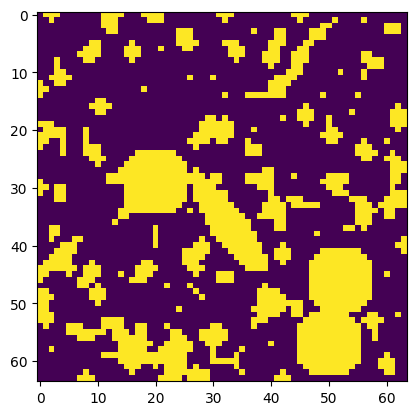

In [57]:
#show image
img = X_test[np.where((y_test == label_picker.value) & (predicted_classes == pred_picker.value))[0][0]]
label = pred_picker.value
plt.imshow(img)

## GradCAM (custom)

In [58]:
#generate heatmap with keras implmentation of gradcam
gradcam = explainabilityModels.make_gradcam_heatmap(img, model)

In [59]:
def plot_compareimg(original, filtered,str1):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    im2 = ax2.imshow(filtered, cmap=plt.cm.jet)
    plt.colorbar(im2,ax=ax2)
    ax2.set_title(str1)
    ax2.axis('off')

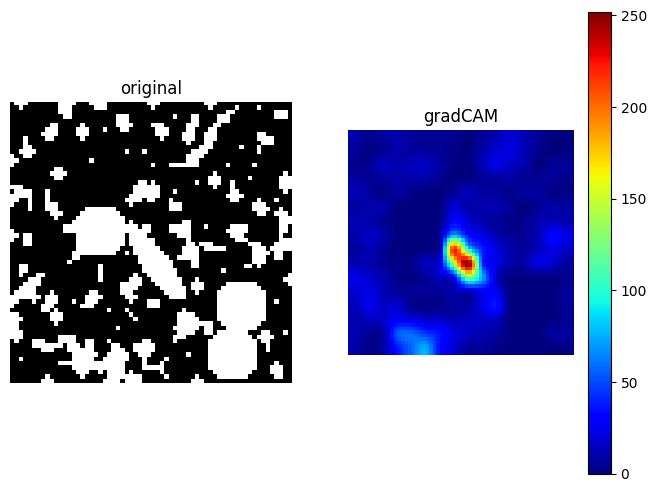

In [60]:
plot_compareimg(img,gradcam,'gradCAM')

## Occlusion Sensitivity Map

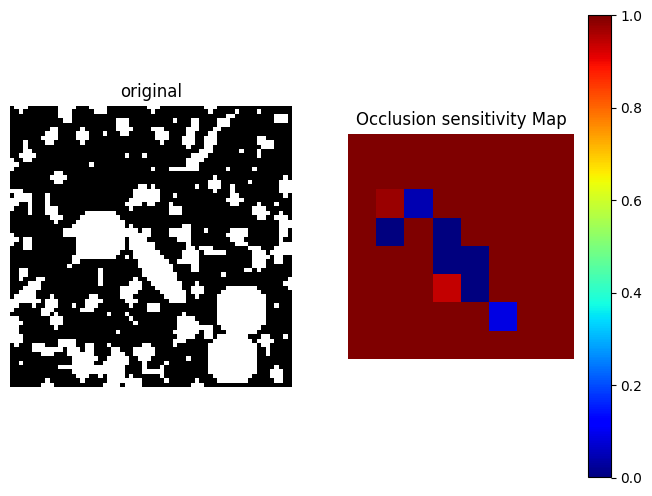

In [61]:
occlusion = explainabilityModels.occlusion_map(img, label, 8, model)
plot_compareimg(img,occlusion,'Occlusion sensitivity Map')

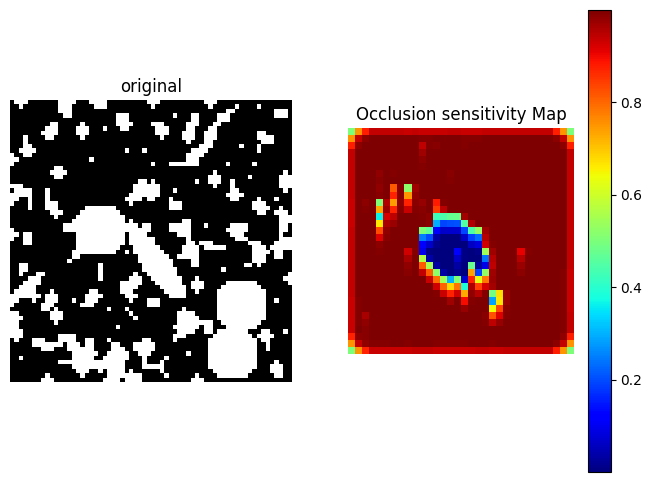

In [37]:
occlusion = explainabilityModels.overlapping_occlusion_map(img, label, 8,2, model)
plot_compareimg(img,occlusion,'Occlusion sensitivity Map')

In [38]:
!pip install tf-keras-vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.0 MB/s eta 0:00:00


Change final activation layer from softmax to linear.
To compute the gradients, it is recommended to change the softmax activation function by
a linear function, since with the softmax the maximization of a class can be achieved by
minimising the scores of the other classes, and using a linear function we ensure that the
optimization concentrates only on the class in question.

In [39]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

# Change final activation layer of the model from softmax to linear
replace2linear = ReplaceToLinear() 

Set which is the class you want to explain

In [62]:
from tf_keras_vis.utils.scores import CategoricalScore

class_score = 0
score = CategoricalScore(class_score)

## Saliency maps


CPU times: user 227 ms, sys: 955 µs, total: 228 ms
Wall time: 232 ms


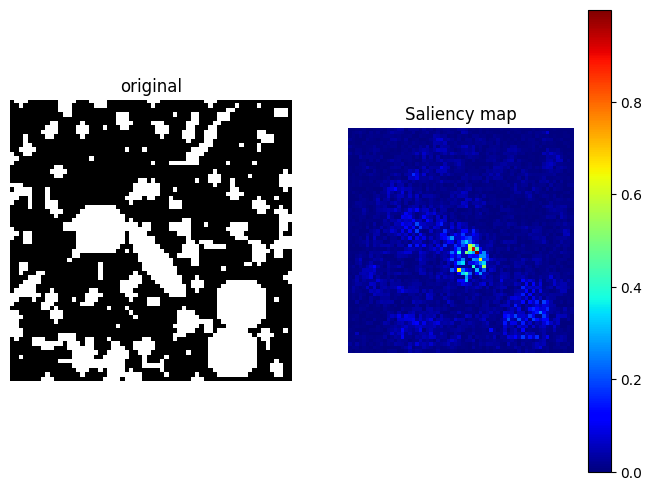

In [63]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# Create Saliency object.
saliency = Saliency(model,model_modifier=replace2linear,clone=True)

# Generate saliency map
saliency_map = saliency(score, img)

# Render
plot_compareimg(img,saliency_map[0],'Saliency map')

## Grad-CAM

Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization

https://arxiv.org/abs/1610.02391




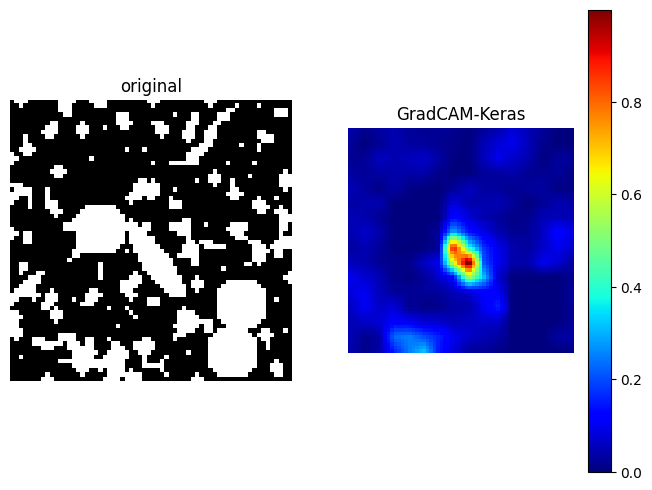

In [64]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam_keras = Gradcam(model,model_modifier=replace2linear,clone=False)

# Generate heatmap with GradCAM
cam = gradcam_keras(score, img, penultimate_layer=-1)

# Render
plot_compareimg(img,cam.squeeze(),'GradCAM-Keras')

## GradCam++

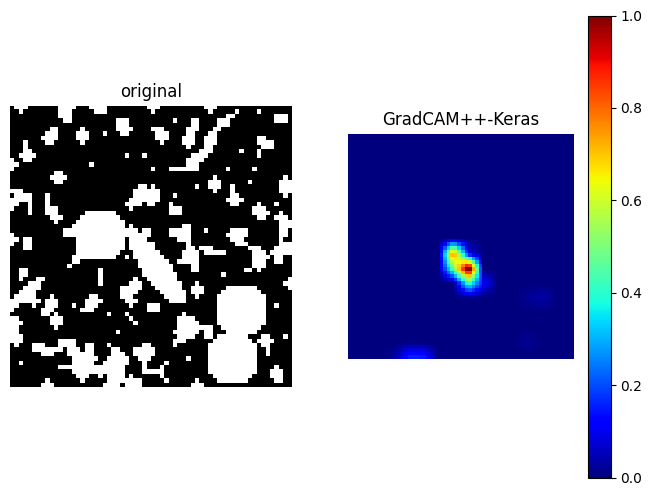

In [65]:
from tf_keras_vis.gradcam import GradcamPlusPlus

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create GradCAM++ object and repalce class name to "GradcamPlusPlus"
gradcamplus = GradcamPlusPlus(model,replace2linear,clone=False)

# Generate heatmap with GradCAM
camplus = gradcamplus(score, img, penultimate_layer=-1)

# Render
plot_compareimg(img,camplus.squeeze(),'GradCAM++-Keras')



## ScoreCAM (fast)

1/1 [==============================] - 0s 148ms/step


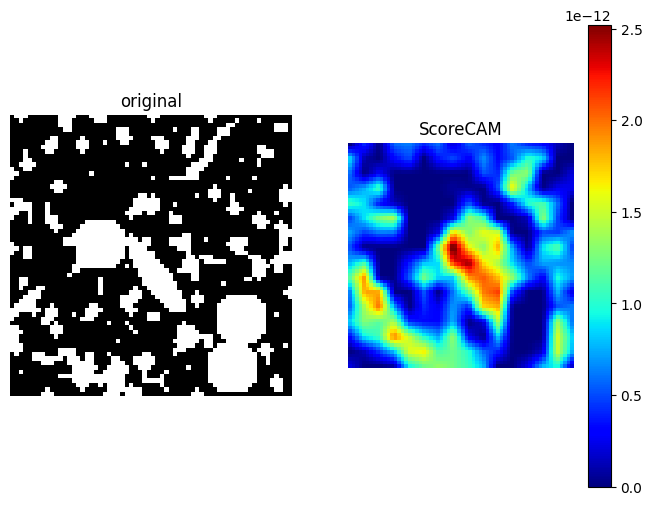

In [66]:
from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
camscore = scorecam(score, img, penultimate_layer=-1,max_N=10)

# Render
plot_compareimg(img,camscore.squeeze(),'ScoreCAM')


Visualize the gradCAM++ explanations for all three classes at once

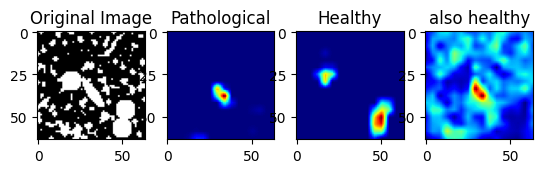

In [68]:
gradcamplus = GradcamPlusPlus(model,replace2linear,clone=False)

camplus0 = gradcamplus(CategoricalScore(0), img, penultimate_layer=-1)
camplus1 = gradcamplus(CategoricalScore(1), img, penultimate_layer=-1)
camplus2 = gradcamplus(CategoricalScore(2), img, penultimate_layer=-1)

fig, ax = plt.subplots(1,4)

ax[0].imshow(img, cmap=plt.cm.gray)
ax[1].imshow(camplus0.squeeze(), cmap=plt.cm.jet)
ax[2].imshow(camplus1.squeeze(), cmap=plt.cm.jet)
ax[3].imshow(camplus2.squeeze(), cmap = plt.cm.jet)

ax[0].set_title("Original Image");
ax[1].set_title("Pathological");
ax[2].set_title("Healthy");
ax[3].set_title('also healthy');

## Visualization of deep features

Define the model for feature extraction

In [69]:
from tensorflow.keras.models import Model

model_FE = Model(inputs=model.input, outputs=model.get_layer('features').output)
model_FE.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256

In [71]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=450f4882f83be9c01847a8ae790d57eb0cada8183d39c9d42a64687214b04753
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=4c6890351766982049055d254ad317f6f1ed92f20a7f74c8cd5918628b150602
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [72]:
# Extract features for your data
features = model_FE.predict(X_train) 
features.shape

126/126 [==============================] - 26s 210ms/step


(4020, 8192)

In [76]:
import umap
# Perform UMAP dimensionality reduction
umap_emb = umap.UMAP().fit_transform(features)
umap_emb.shape

(4020, 2)

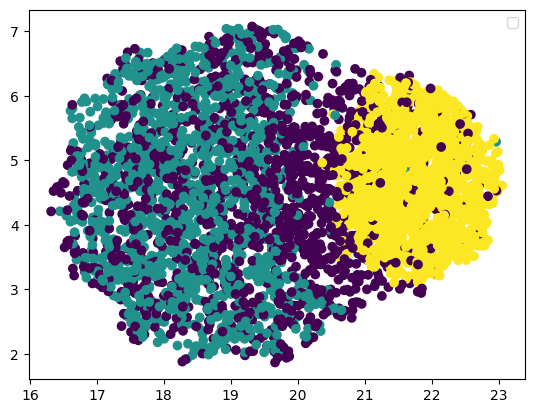

In [86]:
import seaborn as sns
fig,ax = plt.subplots()
ax.scatter(umap_emb[:, 0], umap_emb[:, 1], c=np.argmax(y_train_cat, axis=1))
ax.legend()